In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import tensorflow.keras as keras

from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

### Data Preparation - MNIST

In [61]:
# Loading data
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

print(f"Train images: {train.shape[0]}\nTest images: {test.shape[0]}")

Train images: 42000
Test images: 28000


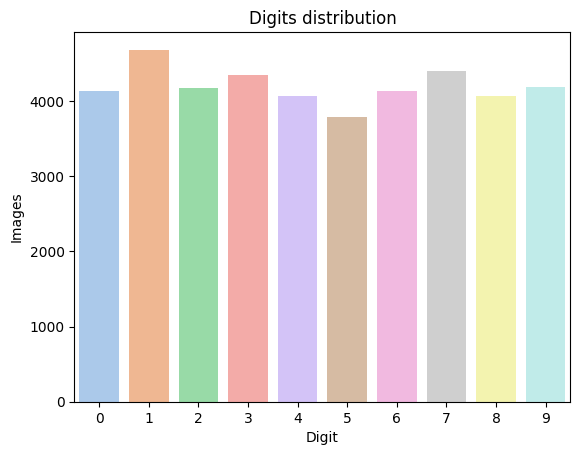

In [62]:
Y_train = train["label"]
X_train = train.drop("label", axis=1)

# Digits distribution
sns.countplot(x=Y_train, hue=Y_train, palette=("pastel"), legend=False)
plt.xlabel("Digit")
plt.ylabel("Images")
plt.title("Digits distribution")
plt.show()

In [63]:
# Checking nulls
print("Train Nulls:", X_train.isnull().values.sum())
print("Test Nulls:", test.isnull().values.sum())

Train Nulls: 0
Test Nulls: 0


In [64]:
# Normalization
X_train = X_train / 255.0
test = test / 255.0

In [65]:
# Reshape
X_train = X_train.values.reshape(-1, 28, 28, 1)
test = test.values.reshape(-1, 28, 28, 1)

In [66]:
# Label Encoding
Y_train = to_categorical(Y_train, num_classes = 10)

In [67]:
# Split Training and Validation Set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1, random_state=0)

X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

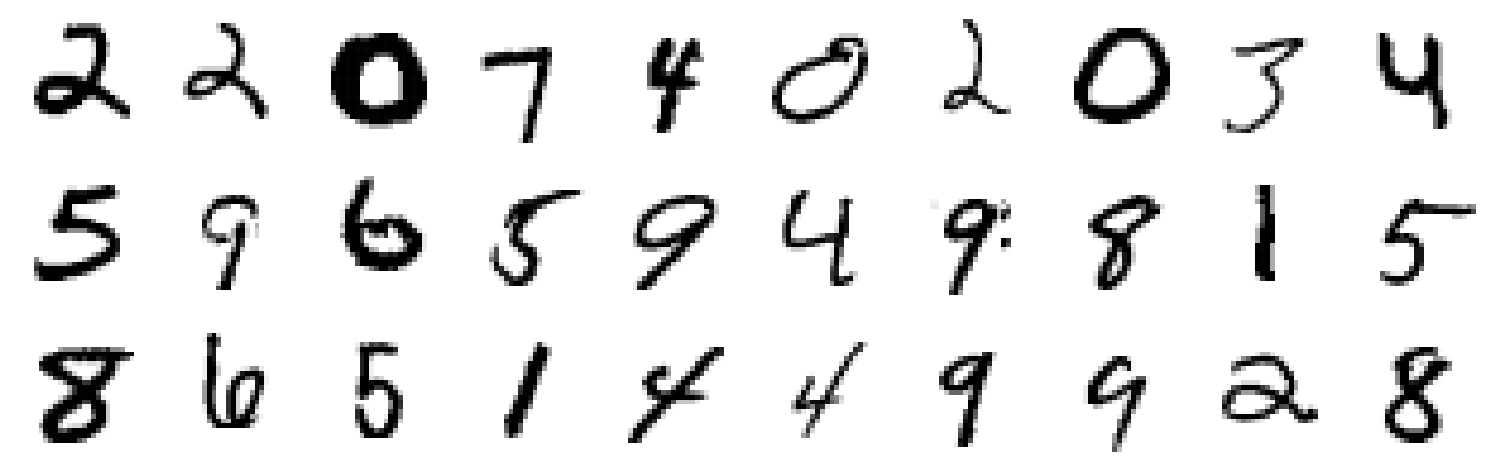

In [68]:
plt.figure(figsize=(15,5))
for i in range(30):  
    plt.subplot(3, 10, i+1)
    plt.imshow(X_train[i].reshape((28,28)),cmap="binary")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
datagen = ImageDataGenerator(rotation_range=10, zoom_range = 0.1, width_shift_range=0.1, height_shift_range=0.1,
                            horizontal_flip=False, vertical_flip=False)

### CNN

In [ ]:
model = Sequential()



model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=["accuracy"])
model.summary()

In [ ]:
epochs = 100
batch_size = 128

train_gen = datagen.flow(X_train, Y_train, batch_size=batch_size)

es = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights=True) 

rlr = ReduceLROnPlateau(monitor = 'val_loss', patience = 3, factor = 0.5, min_lr = 1e-6)

mc = ModelCheckpoint(f'../models/training_model.hdf5', monitor='val_accuracy', save_best_only=True)

learning_hist = model.fit_generator(datagen, epochs = epochs, validation_data = (X_val, Y_val),
                                    callbacks=[es, rlr, mc])

In [ ]:
results = model.predict(test)

results = np.argmax(results, axis = 1)
results = pd.Series(results, name="Label")
results.to_csv("CNN_keras_sub.csv", index=False)
results.head()

### Conclusions and Insights